# UNET 1.0 vs 2.0
The code is for inspection, and cannot be run. Requires the processed dataset, which have been extracted from COCO seperately.

To run the notebook, some paths to the datasets may have to be adjusted depending on the environment.

## Dataloader

In [1]:
import keras
import os
import cv2
import numpy as np

class DataGen(keras.utils.Sequence):

	def __init__(self , path_input , path_mask , batch_size = 8):

		self.ids = os.listdir(path_input)
		self.path_input = path_input
		self.path_mask = path_mask
		self.batch_size = batch_size
		self.on_epoch_end()

	def __load__(self , id_name):

		image_path = os.path.join(self.path_input , id_name)
		mask_path = os.path.join(self.path_mask , id_name) 

		image = cv2.imread(image_path , 1) # 1 specifies RGB format
		image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

		mask = cv2.imread(mask_path , 0)
			
		#normalize image
		image = image / 255.0
		mask = mask / 255.0

		return image , mask

	def __getitem__(self , index):

		if (index + 1)*self.batch_size > len(self.ids):
			self.batch_size = len(self.ids) - index * self.batch_size
			
		file_batch = self.ids[index * self.batch_size : (index + 1) * self.batch_size]

		images = []
		masks = []

		for id_name in file_batch : 
			
			_img , _mask = self.__load__(id_name)
			images.append(_img)
			masks.append(_mask)


		images = np.array(images)
		masks = np.array(masks)


		return images , masks


	def on_epoch_end(self):
		pass


	def __len__(self):
		return int(np.ceil(len(self.ids) / float(self.batch_size)))


## UNet 1.0

In [2]:
import keras

import keras.backend as K

from keras.models import Model
from keras.optimizers import Adam
from keras.activations import softmax
from keras.layers import *
from keras import metrics

################
### UNET 1.0 ###
################

def down_block(prev_layer,no_filters):
    x = Conv2D(no_filters, kernel_size = (3,3), padding="same", kernel_initializer="he_normal" )(prev_layer)
    x = Activation('relu')(x)
    
    x = Conv2D(no_filters, kernel_size = (3,3), padding="same",  kernel_initializer="he_normal" )(x)
    x_concat = Activation('relu')(x)

    x = MaxPooling2D(pool_size=(2,2))(x_concat)
    return (x,x_concat)


def up_block(prev_layer,concat_layer,no_filters):
    x = Conv2DTranspose(no_filters,kernel_size=(3,3),strides=(2,2), padding="same", activation='relu',  kernel_initializer="he_normal" )(prev_layer)
    x = Concatenate()([concat_layer,x])

    x = Conv2D(no_filters, kernel_size = (3,3),padding="same",  kernel_initializer="he_normal" )(x)
    x = Activation('relu')(x)
    
    x = Conv2D(no_filters, kernel_size = (3,3),padding="same",  kernel_initializer="he_normal" )(x)
    x = Activation('relu')(x)

    return x

# First step
inputs = Input(shape=(256,256,3))

x = Conv2D(64, kernel_size = (3,3),padding="same",  kernel_initializer="he_normal" )(inputs)
x = Activation('relu')(x)

x_0 = Conv2D(64, kernel_size = (3,3),padding="same",  kernel_initializer="he_normal" )(x)
x = Activation('relu')(x)
x = MaxPooling2D(pool_size=(2,2))(x_0)


# Down
(x,x_1) = down_block(x,128)
(x,x_2) = down_block(x,256)
(x,x_3) = down_block(x,512)

#Bottle neck
x = Conv2D(1024, kernel_size = (3,3),padding="same", kernel_initializer="he_normal" )(x)
x = Activation('relu')(x)
x = Conv2D(1024, kernel_size = (3,3),padding="same", kernel_initializer="he_normal" )(x)
x = Activation('relu')(x)

# Up
x = up_block(x,x_3,512)
x = up_block(x,x_2,256)
x = up_block(x,x_1,128)
x = up_block(x,x_0,64)


x = Conv2D(1, kernel_size = (1,1),padding="same" ,kernel_initializer="he_normal")(x)
x = Activation('sigmoid')(x)

def dice_coef(y_true, y_pred, smooth=1):
    intersection = K.sum(y_true * y_pred)
    union = K.sum(y_true) + K.sum(y_pred)
    return K.mean( (2. * intersection + smooth) / (union + smooth))
    
def dice_loss(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred)
 
def intersection_over_union(y_true,y_pred):
    y_true = K.flatten(y_true)
    y_pred = K.flatten(y_pred)
    
    greater = K.greater_equal(y_pred, 0.5) #will return boolean values
    y_pred = K.cast(greater, dtype=K.floatx()) #will convert bool to 0 and 1

    intersection = K.sum(y_true * y_pred)
    union = K.sum(y_true + y_pred - y_true * y_pred)
    return (intersection) / (union)

decayed_lr = keras.optimizers.schedules.ExponentialDecay(5e-5, 10 * 360, 0.96)



unet = Model(inputs,x)
unet.compile(optimizer=Adam(learning_rate=decayed_lr), loss=dice_loss, metrics=[intersection_over_union, "accuracy"])
unet.summary()


Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
activation (Activation)         (None, 256, 256, 64) 0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 64) 36928       activation[0][0]                 
_______________________________________________________________________________________

## UNet 2.0

In [3]:
import keras

import keras.backend as K

from keras.preprocessing import image
from keras.models import Model,Sequential
from keras.optimizers import Adam
from keras.activations import softmax
from keras.layers import *
from keras import metrics
from keras.utils.vis_utils import plot_model
import tensorflow as tf
################
### UNET 2.0 ###
################

def in_between_block(prev_layer,no_filters,length):
    x_sc = Conv2D(no_filters, kernel_size = (1,1), padding="same", kernel_initializer="he_normal")(prev_layer)
    x_sc = BatchNormalization(axis=3)(x_sc)

    x = Conv2D(no_filters, kernel_size = (3,3), padding="same",kernel_initializer="he_normal")(prev_layer)
    x = BatchNormalization(axis=3)(x)
    x = Activation("relu")(x)
    x = Add()([x,x_sc])
    x = Activation('relu')(x)
    x = BatchNormalization(axis=3)(x)

    for i in range(length-1):
      
      x_sc = Conv2D(no_filters, kernel_size = (1,1), padding="same", kernel_initializer="he_normal")(x)
      x_sc = BatchNormalization(axis=3)(x_sc)
      x = Conv2D(no_filters, kernel_size = (3,3), padding="same",kernel_initializer="he_normal")(x)
      x = BatchNormalization(axis=3)(x)
      x = Activation("relu")(x)
      
      x = Add()([x,x_sc])
      x = Activation('relu')(x)
      x = BatchNormalization(axis=3)(x)


    return x

def basic_res_block(prev_layer,no_filters):

    x_skip = Conv2D(int(no_filters*0.167)+int(no_filters*0.333)+int(no_filters*0.5),kernel_size=(1,1), padding="same", kernel_initializer="he_normal")(prev_layer)
    x_skip = BatchNormalization(axis=3,scale=False)(x_skip)

    x_1 = Conv2D(int(no_filters*0.167), kernel_size = (3,3), padding="same", kernel_initializer="he_normal")(prev_layer)
    x_1 = BatchNormalization(axis=3)(x_1)
    x_1 = Activation("relu")(x_1)
    x_2 = Conv2D(int(no_filters*0.333), kernel_size = (3,3), padding="same", kernel_initializer="he_normal")(x_1)
    x_2 = BatchNormalization(axis=3)(x_2)
    x_2 = Activation("relu")(x_2)
    x_3 = Conv2D(int(no_filters*0.5), kernel_size = (3,3), padding="same", kernel_initializer="he_normal")(x_2)
    x_3 = BatchNormalization(axis=3)(x_3)
    x_3 = Activation("relu")(x_3)

    output_layer = concatenate([x_1,x_2,x_3],axis=3)
    output_layer = BatchNormalization(axis = 3)(output_layer)

    output_layer = add([x_skip,output_layer]) 
    output_layer = Activation('relu')(output_layer)
    output_layer = BatchNormalization(axis=3)(output_layer)
    return output_layer

def multi_res_down_block(prev_layer,no_filters,length):
    output_layer = basic_res_block(prev_layer,no_filters)

    res_path = in_between_block(output_layer,no_filters,length)

    pool = MaxPooling2D(pool_size=(2,2),strides=(2,2))(output_layer)
    return pool,res_path

def multi_res_up_block(prev_layer,concat_layer,no_filters):

    x_up = Conv2DTranspose(no_filters,kernel_size=(2,2), strides=(2,2),padding="same",kernel_initializer="he_normal")(prev_layer)
    x_concat = Concatenate()([x_up,concat_layer])
    output_layer = basic_res_block(x_concat,no_filters);
    return output_layer

def dice_coef(y_true, y_pred, smooth=1):
    intersection = K.sum(y_true * y_pred)
    union = K.sum(y_true) + K.sum(y_pred)
    return K.mean( (2. * intersection + smooth) / (union + smooth))

def dice_loss(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred)


# First step
inputs = Input(shape=(256,256,3))
init_filter_size = 64

# Down
down1,res_path1 = multi_res_down_block(inputs,init_filter_size,4)
down2,res_path2 = multi_res_down_block(down1,init_filter_size*2,3)
down3,res_path3 = multi_res_down_block(down2,init_filter_size*4,2)
down4,res_path4 = multi_res_down_block(down3,init_filter_size*8,1)


# bottleneck
bottle_neck = basic_res_block(down4,init_filter_size*16)

# Up
up1 = multi_res_up_block(bottle_neck,res_path4,init_filter_size*8)
up2 = multi_res_up_block(up1,res_path3,init_filter_size*4)
up3 = multi_res_up_block(up2,res_path2, init_filter_size*2)
up4 = multi_res_up_block(up3,res_path1,init_filter_size)

# output

output = Conv2D(1, kernel_size = (1,1),padding="same" ,kernel_initializer="he_normal" )(up4)
output = BatchNormalization(scale=True)(output)
output = Activation(keras.activations.sigmoid)(output)

unet2 = Model(inputs,output)


def intersection_over_union(y_true,y_pred):
    greater = K.greater_equal(y_pred, 0.5) #will return boolean values
    y_pred = K.cast(greater, dtype=K.floatx()) #will convert bool to 0 and 1
    intersection = K.sum(y_true * y_pred)
    union = K.sum(y_true + y_pred - y_true * y_pred)
    return (intersection) / (union)

decayed_lr = keras.optimizers.schedules.ExponentialDecay(1e-2, 3600, 0.96)




opt = keras.optimizers.Adam(learning_rate=decayed_lr)

unet2.compile(optimizer=opt, loss=dice_loss, metrics=[intersection_over_union, "accuracy"])
unet2.summary()


Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d_20 (Conv2D)              (None, 256, 256, 10) 280         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 256, 256, 10) 40          conv2d_20[0][0]                  
__________________________________________________________________________________________________
activation_19 (Activation)      (None, 256, 256, 10) 0           batch_normalization_1[0][0]      
_______________________________________________________________________________________

## Training


In [4]:
import matplotlib.pyplot as plt

def show_history(history):
  plt.figure(figsize=(20,6))

  # summarize history for accuracy
  plt.subplot(121)
  plt.plot(history.history['intersection_over_union'])
  plt.plot(history.history['val_intersection_over_union'])
  plt.title('intersection_over_union')
  plt.ylabel('intersection_over_union')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')

  # summarize history for loss
  plt.subplot(122)
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()



### UNet 1.0


In [ ]:
### Training ###

no_images_total = 4320
no_images_train = 2880
no_images_val = 720
no_images_test = 720

no_epochs = 100
batch_size = 8
no_iterations = 360 #360

train_gen = DataGen(path_input = "dataset/train/images/" , path_mask = "dataset/train/masks/" , batch_size = batch_size)
val_gen = DataGen(path_input =  "dataset/val/images/", path_mask =  "dataset/val/masks/", batch_size = batch_size)

train_steps =  len(os.listdir( "dataset/train/images/"))/batch_size


In [ ]:
import keras.callbacks as cb
from keras.callbacks import CSVLogger

checkpoint_filepath = 'checkpoint1'
filepath = checkpoint_filepath + "-{epoch:02d}.hdf5"

csv_logger = CSVLogger("model_history_log_unet1.csv", append=True)

checkpoint = cb.ModelCheckpoint(filepath, monitor='val_intersection_over_union', verbose=1, save_best_only=True, mode='max')

history_unet1 = unet.fit(train_gen , validation_data = val_gen , steps_per_epoch = no_iterations , epochs=no_epochs, shuffle=True, workers=3, callbacks=[checkpoint, csv_logger])

In [ ]:
show_history(history_unet1)

### UNet 2.0

In [ ]:
### Training ###

no_images_total = 4320
no_images_train = 2880
no_images_val = 720
no_images_test = 720

no_epochs = 100
batch_size = 8
no_iterations = 360 #360

train_gen = DataGen(path_input = "dataset/train/images/" , path_mask = "dataset/train/masks/" , batch_size = batch_size)
val_gen = DataGen(path_input =  "dataset/val/images/", path_mask =  "dataset/val/masks/", batch_size = batch_size)

train_steps =  len(os.listdir( "dataset/train/images/"))/batch_size


In [ ]:
import keras.callbacks as cb
from keras.callbacks import CSVLogger

checkpoint_filepath = 'checkpoint2'
filepath = checkpoint_filepath + "39-{epoch:02d}.hdf5"

csv_logger = CSVLogger("model_history_log_unet2.csv", append=True)

checkpoint = cb.ModelCheckpoint(filepath, monitor='val_intersection_over_union', verbose=1, save_best_only=True, mode='max')

history_unet2 = unet.fit(train_gen , validation_data = val_gen , steps_per_epoch = no_iterations , epochs=no_epochs, shuffle=True, workers=3, callbacks=[checkpoint,csv_logger])

In [ ]:
show_history(history_unet2)

## Evaluation

In [ ]:
batch_size = 8
test_gen = DataGen(path_input =  "dataset/test/images/", path_mask =  "dataset/test/masks/", batch_size = batch_size)

### UNet 1.0

In [ ]:
unet.evaluate(test_gen, batch_size=batch_size, workers=3)

### UNet 2.0

In [ ]:
unet2.evaluate(test_gen, batch_size=batch_size, workers=3)

### Comparison of the 8 images

In [ ]:
def compare_unets(images, unet1, unet2, ground_truths, epoch_offset=0):
    len_images = len(images)
    len_unet1 = len(unet1)
    len_unet2 = len(unet2)
 
    BIGGER_SIZE = 20


    plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes
    plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
    plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
    plt.rc('xtick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
    plt.rc('legend', fontsize=BIGGER_SIZE)    # legend fontsize
    plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

    img_size = 256
    for i in range(len_images):
        fig = plt.figure()
        fig.set_figheight(24)
        fig.set_figwidth(24)
        fig.subplots_adjust(hspace=0.2, wspace=0.2)

    
        ax = fig.add_subplot(1, 4, 1)
        ax.set_title("UNet 1.0")
        ax.imshow(np.reshape(unet1[i] * 255, (img_size, img_size)), cmap="gray")

        ax = fig.add_subplot(1, 4, 2)
        ax.set_title("UNet 2.0")
        ax.imshow(np.reshape(unet2[i] * 255, (img_size, img_size)), cmap="gray")

        ax = fig.add_subplot(1, 4, 3)
        ax.set_title("Ground Truth")
        ax.imshow(np.reshape(ground_truths[i] *255, (img_size, img_size)), cmap="gray")

        ax = fig.add_subplot(1, 4, 4)
        ax.set_title("Image Reference")
        ax.imshow(images[i])

    

In [ ]:
test_gen = DataGen(path_input ="the8/images", path_mask =  "the8/masks", batch_size = batch_size)

x, y = test_gen.__getitem__(0)
unet1_pred = unet.predict(x)
unet2_pred = unet2.predict(x)



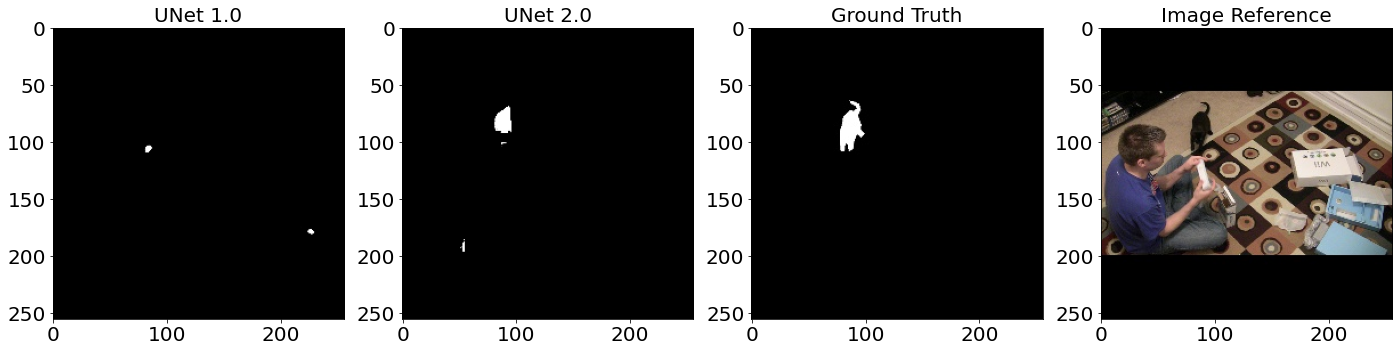

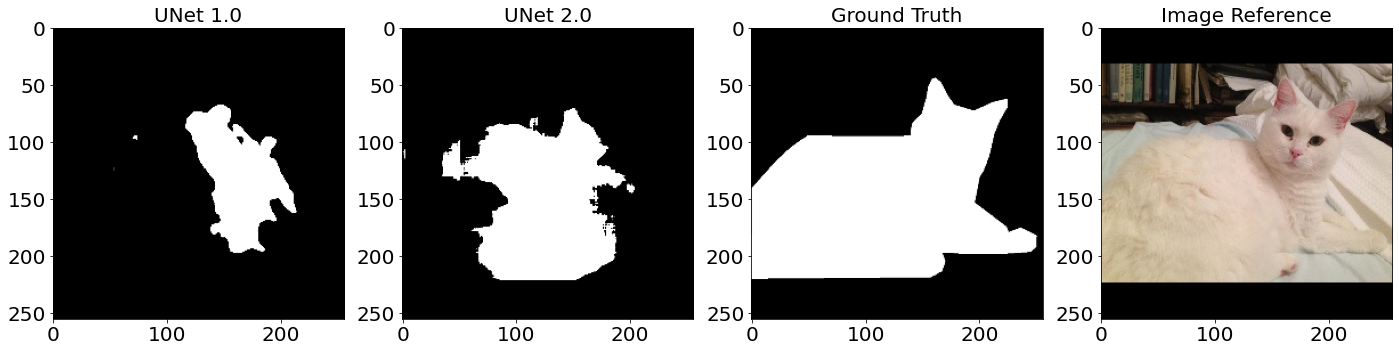

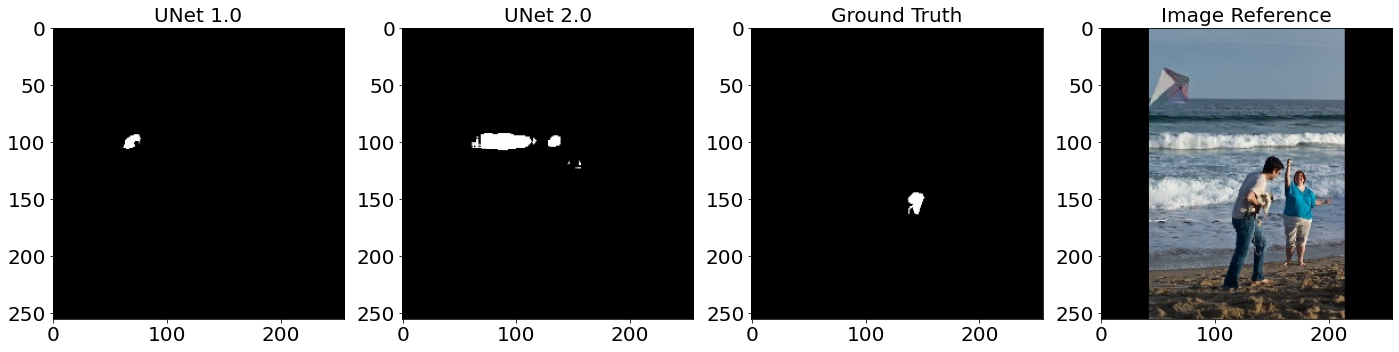

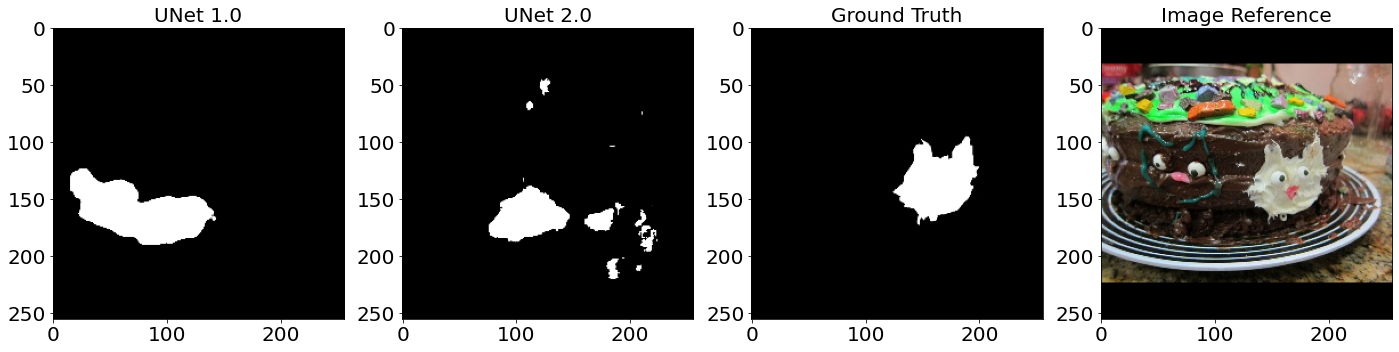

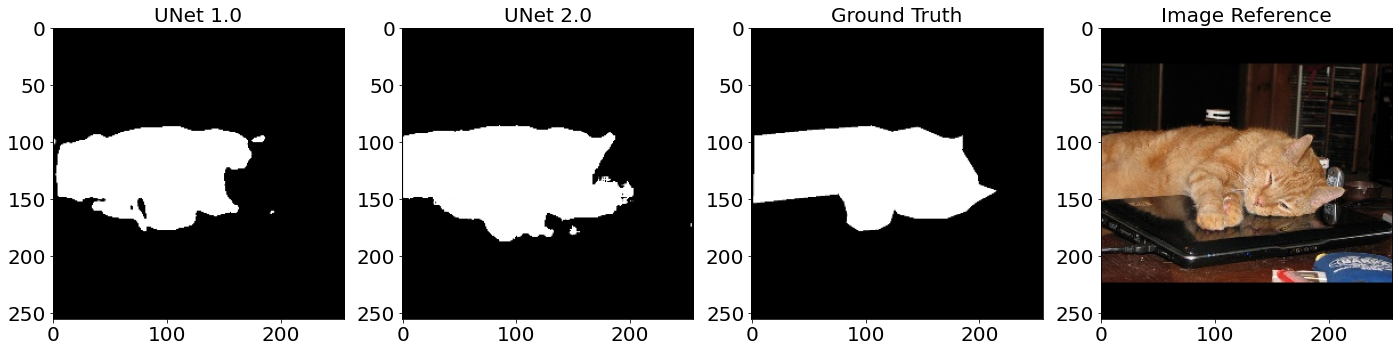

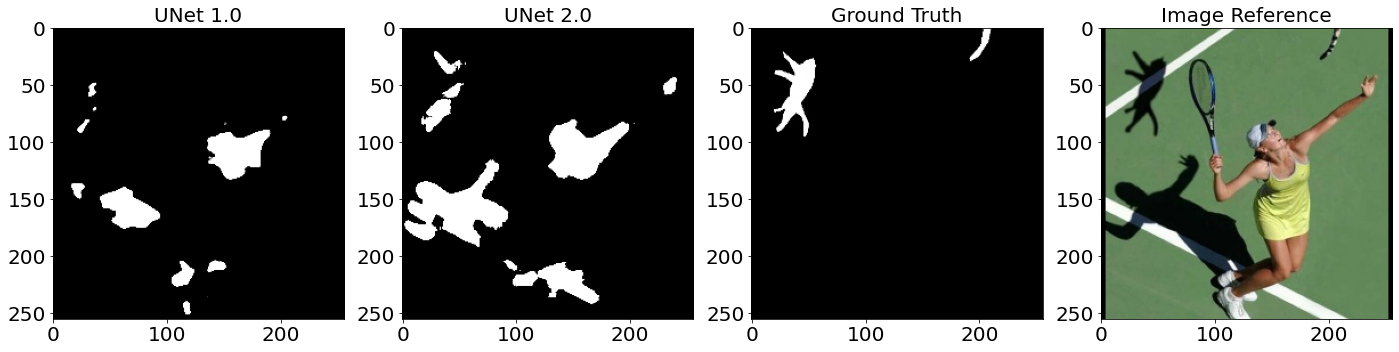

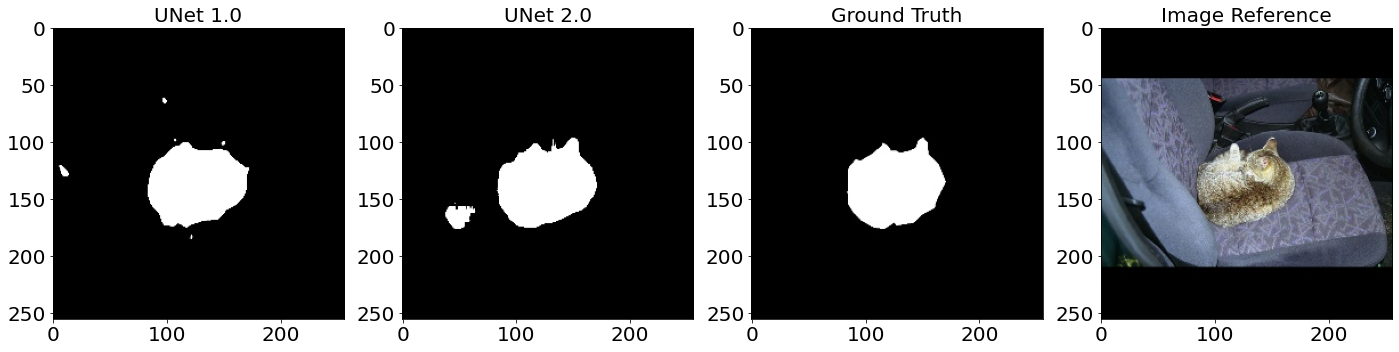

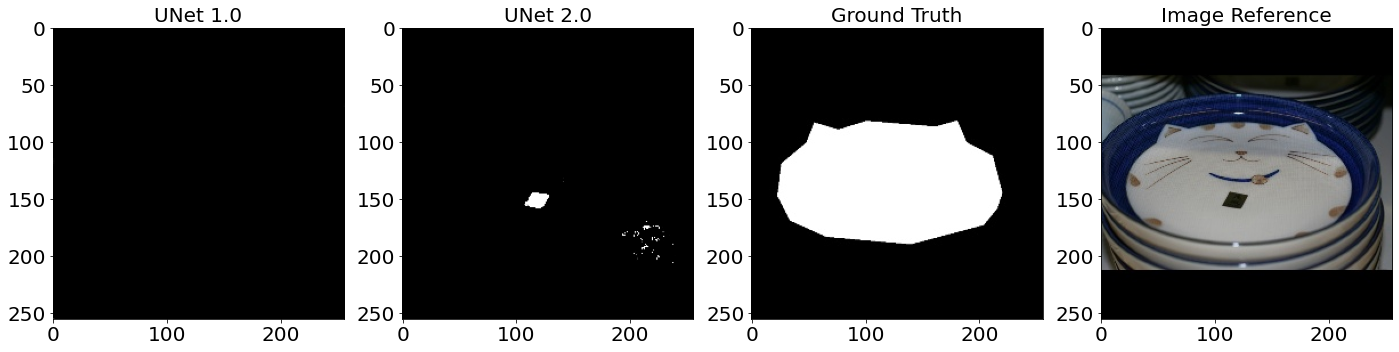

In [ ]:
unet1_pred >= 0.5
unet2_pred >= 0.5
compare_unets(x,unet1_pred, unet2_pred,y)